<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Relative Humidity Predictor

_Author: Nujood Alwhibi_

---

# Problem Statment

predict the **Relative Humidity** of a given point of time based on the all other features affecting the change in relative humidity.


---

In [1]:
# Import libraries necessary for the project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, ShuffleSplit, learning_curve, train_test_split, cross_val_score
from sklearn import preprocessing
from sklearn.metrics import r2_score, make_scorer, mean_squared_error, mean_absolute_error
from sklearn.feature_selection import SelectFromModel

%matplotlib inline
%load_ext autoreload

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('AirQualityUCI_EDA.csv')
df.head()

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Hour,Weekday,Weekend,Month
0,2.6,1360.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,18,2,0,3
1,2.0,1292.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,19,2,0,3
2,2.2,1402.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,20,2,0,3
3,2.2,1376.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,21,2,0,3
4,1.6,1272.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,22,2,0,3




# Modeling

---

## 1. Splitting the data into train and test sets

In [33]:
# Set the Features and Target variable
feature_cols = df.drop(['RH'], axis = 1).columns
X = df[feature_cols]
y = df.RH

# split the data into test/train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7485, 15)

(1872, 15)

(7485,)

(1872,)

## 2. Build the Model
  _Random Forest Regressor will be used to predict our target_.

**The performance will be evaluated using the below metrics:**
* Root Mean Square Error (RMSE)
* Mean Absolute Error (MAE)
* R-squared (R<sup>2</sup>)
* Adjusted R-squared (Adjusted R<sup>2</sup>) 

In [34]:
def report_generator(y_test, y_pred):
    RMSE = np.sqrt(mean_squared_error(y_test,y_pred))
    MAE = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    adj_r2 = 1 - (1-r2)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1) 
    print("RMSE: {0:.4f} \nMAE: {1:.4f} \nR-Squared: {2:.4f} \nAdjusted R-Squared: {3:.4f}".format(RMSE, MAE, r2, adj_r2))

**First, we will start predicting using the default setting**

In [35]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor()
model = regressor.fit(X_train,y_train)

In [36]:
y_pred = model.predict(X_test)

**Evaluate the performance**

In [37]:
report_generator(y_test, y_pred)

RMSE: 0.7052 
MAE: 0.4918 
R-Squared: 0.9983 
Adjusted R-Squared: 0.9983


## 3. Analyzing Model Performance
Each graph visualizes the learning curves of the model for both training and testing as the size of the training set is increased. The model is scored on both the training and testing sets using R<sup>2</sup>


In [17]:
def ModelLearning(X, y):

    # Create 10 cross-validation sets for training and testing
    cv = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 0)

    # Generate the training set sizes increasing by 50
    train_sizes = np.rint(np.linspace(1, X.shape[0]*0.8 - 1, 9)).astype(int)

    fig = plt.figure(figsize=(15,10))

    for k, depth in enumerate([1,3,6,10]):

        # Create a random forest regressor
        regressor = RandomForestRegressor(max_depth = depth)

        # Calculate the training and testing scores
        sizes, train_scores, test_scores = learning_curve(regressor, X, y, \
            cv = cv, train_sizes = train_sizes, scoring = 'r2')

        # Find the mean and standard deviation for smoothing
        train_std = np.std(train_scores, axis = 1)
        train_mean = np.mean(train_scores, axis = 1)
        test_std = np.std(test_scores, axis = 1)
        test_mean = np.mean(test_scores, axis = 1)

        # Subplot the learning curve
        ax = fig.add_subplot(2, 2, k+1)
        ax.plot(sizes, train_mean, 'o-', color = 'r', label = 'Training Score')
        ax.plot(sizes, test_mean, 'o-', color = 'purple', label = 'Testing Score')
        ax.fill_between(sizes, train_mean - train_std, \
            train_mean + train_std, alpha = 0.15, color = 'r')
        ax.fill_between(sizes, test_mean - test_std, \
            test_mean + test_std, alpha = 0.15, color = 'purple')

        ax.set_title('max_depth = %s'%(depth))
        ax.set_xlabel('Training Set Size')
        ax.set_ylabel('Score')
        ax.set_xlim([0, X.shape[0]*0.8])
        ax.set_ylim([-0.05, 1.05])

    # Visual
    ax.legend(bbox_to_anchor=(1.05, 2.05), loc='lower left', borderaxespad = 0.)
    fig.suptitle('Random Forest Regressor Learning Performances', fontsize = 16, y = 1.03)
    fig.tight_layout()
    fig.show()

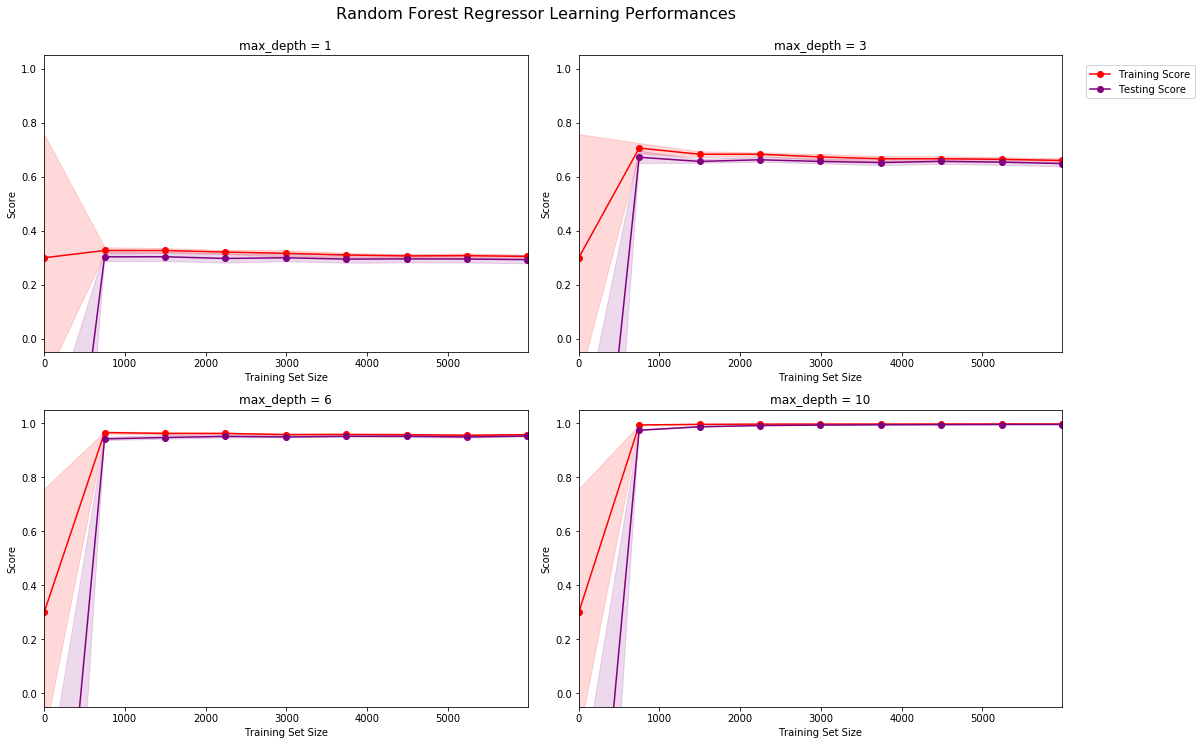

In [18]:
ModelLearning(X_train, y_train)

**in max_depth of 10, As more training points are added, both training curve and testing curve are converging to about 0.9 score.**

Having more training points will benefit the model by making curve converge. Once converged, adding more training points seems to have no significant help.

## 4. Complexity Curves

In [19]:
from sklearn.model_selection import validation_curve

def ModelComplexity(X, y):

    # Create 10 cross-validation sets for training and testing
    cv = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 0)

    # Vary the max_depth parameter from 1 to 10
    max_depth = np.arange(1,11)

    # Calculate the training and testing scores
    train_scores, test_scores = validation_curve(RandomForestRegressor(), X, y, \
        param_name = "max_depth", param_range = max_depth, cv = cv, scoring = 'r2')

    # Find the mean and standard deviation for smoothing
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Plot the validation curve
    plt.figure(figsize=(15,10))
    plt.title('Random Forest Regressor Complexity Performance')
    plt.plot(max_depth, train_mean, 'o-', color = 'r', label = 'Training Score')
    plt.plot(max_depth, test_mean, 'o-', color = 'g', label = 'Validation Score')
    plt.fill_between(max_depth, train_mean - train_std, \
        train_mean + train_std, alpha = 0.15, color = 'r')
    plt.fill_between(max_depth, test_mean - test_std, \
        test_mean + test_std, alpha = 0.15, color = 'g')

    # Visual aesthetics
    plt.legend(loc = 'lower right')
    plt.xlabel('Maximum Depth')
    plt.ylabel('Score')
    plt.ylim([-0.05,1.05])
    plt.show()

graph for a random forest model that has been trained and validated on the training data using different maximum depths. The graph produces two complexity curves, one for training and one for validation.

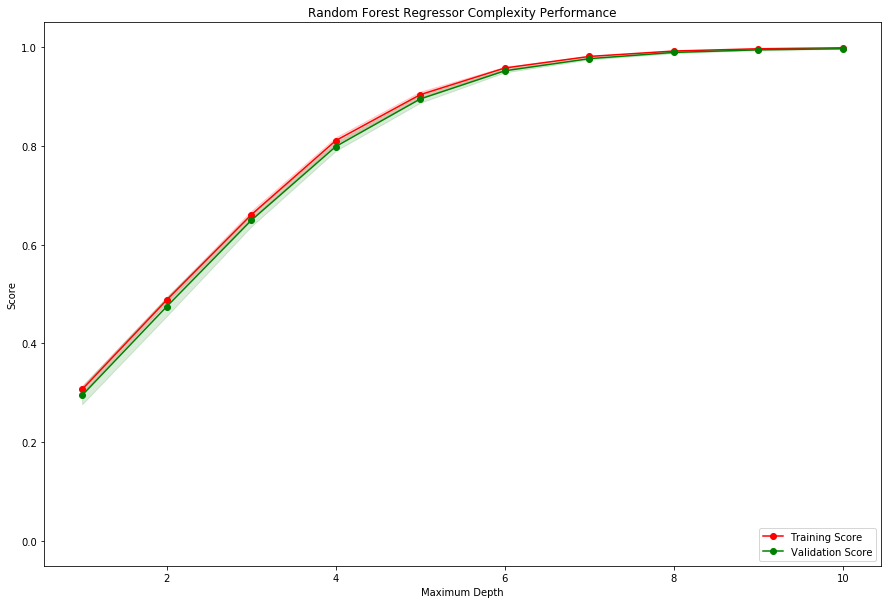

In [20]:
ModelComplexity(X_train, y_train)

when the model was trained with max depth of 1, both training and validation scores seems very low and so close to each other.

when the model was trained with max depth of 10, the model doesn't seem to suffer from high variance and both have a very high score, so the performance seem reasonably good.

---

# 5. Hyperparameters Optimisation Technique:
## ● Randomized Search
Randomized Search is a common pratice for tuning hyperparameters. Basically what it does is that:

it search only a random subset of the provided parameter values. This allows us to explicitly control the number of different parameter combinations that are attempted, which we can alter depending on the computational time available.

----
# 6. Model Validation Technique:
## ● Cross-Validation
It's a model validation technique for assessing how the results of a statistical analysis will generalize to an independent data set. what it does is that:

1- The data set is divided into k subsets, and the train & test procedure is repeated k times.

2- Each time, one of the k subsets is used as the test set and the other k-1 subsets are put together to form a training set.

The benefit is that it matters less how the data gets divided, every data point gets to be in a test set exactly once, and gets to be in a training set k-1 times. In this way, model will suffer less from high variance. Otherwise, GridSearch may return a tuned model that relies on a specific division of train and test sets but predict poorly in a general situation.

---

## 7. Fit the Optimal Model

In [21]:
def fit_model(X, y):

    cv_sets = ShuffleSplit(test_size = 0.20, random_state = 0) 
    
    params = {'n_estimators':[100, 120, 140], 
              'min_samples_leaf':[1, 2, 3],
              'max_depth':list(range(1, 11)),
              'max_features':[0.05, 0.1, 0.15, 0.2]}

    n_iter_search = 10
    
    regressor = RandomForestRegressor()

    score = make_scorer(r2_score)

    grid = RandomizedSearchCV(regressor, params, n_iter = n_iter_search, scoring = score, cv = cv_sets)

    grid = grid.fit(X, y)

    # Return the optimal model
    return grid.best_estimator_

In [22]:
# Fit the training data to the model using grid search
reg = fit_model(X_train, y_train)

# Produce the value for 'max_depth'
print("Parameter are {} for the optimal model.".format(reg.get_params()))

Parameter are {'bootstrap': True, 'criterion': 'mse', 'max_depth': 10, 'max_features': 0.2, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 120, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False} for the optimal model.


In [23]:
y_opt_pred = reg.predict(X_test)

**Evalute the performance**

In [24]:
report_generator(y_test, y_opt_pred)

RMSE: 5.9266 
MAE: 4.5262 
R-Squared: 0.8826 
Adjusted R-Squared: 0.8816


In [25]:
score_train = cross_val_score(reg, X_train, y_train).mean()
score_test = cross_val_score(reg, X_test, y_test).mean()

print("Score with the train set = %.2f" % score_train)
print("Score with the test set = %.2f" % score_test)

Score with the train set = 0.87
Score with the test set = 0.82


## 8. Prdicted vs. Actual

Compare the predicted values with the actual values.

In [26]:
d = {'true' : list(y_test),
     'predicted' : pd.Series(y_opt_pred)
    }

pd.DataFrame(d).head()

,predicted,true
0,34.406234,34.9
1,51.485825,49.9
2,35.235629,32.3
3,40.702714,34.0
4,41.003096,39.2


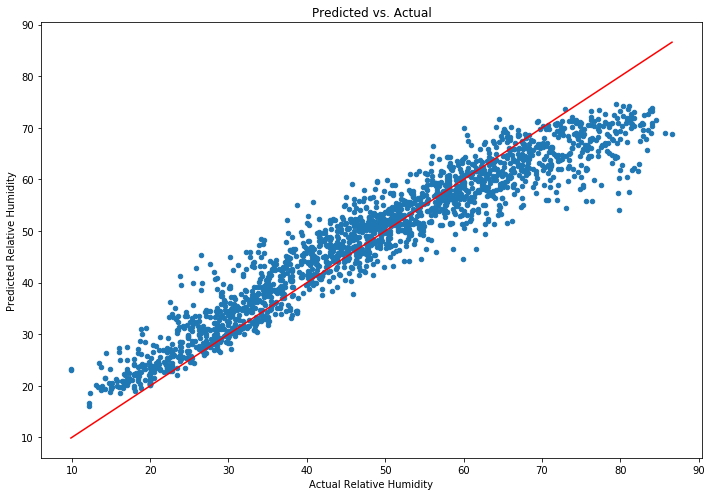

In [27]:
plt.figure(figsize=(10, 7))
plt.scatter(y_test, y_opt_pred, s=20)
plt.title('Predicted vs. Actual')
plt.xlabel('Actual Relative Humidity')
plt.ylabel('Predicted Relative Humidity')

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red")
plt.tight_layout()

## 9. Identify Feature Importance

use *feature_importances* attribute to identify the features with the highest importance score.

In [42]:
feature_importances = pd.DataFrame(reg.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
T,0.316155
AH,0.147758
Hour,0.137416
Month,0.110300
PT08.S4(NO2),0.058129
PT08.S5(O3),0.034250
PT08.S3(NOx),0.033250
PT08.S1(CO),0.030341
PT08.S2(NMHC),0.030208
NOx(GT),0.029902


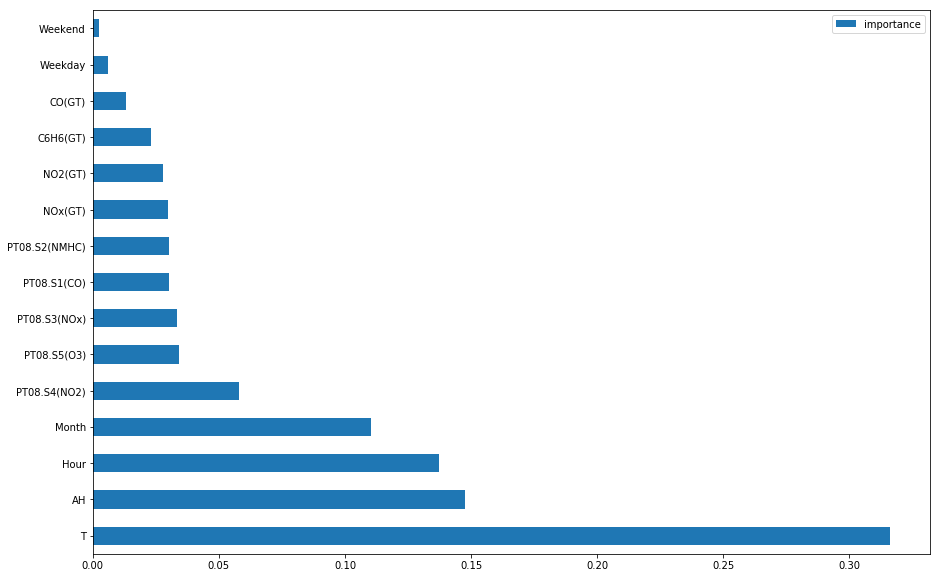

In [41]:
feature_importances.plot(kind='barh',figsize=(15,10))

The Temprature and Absoulute Humidity have top importance scores, it makes perfect sense looking at the definition of Relative humidity: the ratio of the current **absolute humidity** to the highest possible absolute humidity (which depends on the current air **temperature**).